<a href="https://colab.research.google.com/github/jiahengzhang66/data-xspring2019/blob/master/Machine_learning_data_x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q mysql.connector

    100% |████████████████████████████████| 11.9MB 2.8MB/s 


In [4]:
!pip install -U -q PyDrive

    100% |████████████████████████████████| 993kB 17.7MB/s 


In [5]:
!pip install schedule

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import sklearn
import mysql.connector
import seaborn as sns
import pytz

pd.set_option("display.max_columns",None)

In [7]:
mydb = mysql.connector.connect(host="rds-mysql-smartq.c5jgo1t3trwc.us-west-1.rds.amazonaws.com",
    user="smartQ",
    passwd="smartQdatax",
    database="smartQ")
mycursor = mydb.cursor()

sql = """
select e.*, 
 CASE
  WHEN type = 'Federal Holiday' Then 1
        ELSE 0
 END is_federal_holiday,
    CASE
  WHEN type = 'School Holiday' Then 1
        ELSE 0
 END is_school_holiday
from
(select d.*, Holidays.type from
(select c.*,RideDurations.ride_time_mins from
(select
 b.db_id,
    b.theme_land_name,
    b.ride_id,
    RideInUse.ride_name,
    RideInUse.ride_category,
    b.ride_active,
    b.`status`,
    RideInUse.fastpass_active,
    b.date_time,
    b.`date`,
    b.minute_of_day,
    b.hour_of_day,
    b.day_of_week,
    b.day_of_month,
    b.month_of_year,
    b.wait_time_mins,
    b.date_time_unix
 from
(Select
 LiveData.id as db_id, 
 substring_index(LiveData.theme_ride_id,'_',1) as theme_land_name,
 substring_index(LiveData.theme_ride_id,'_',-1) as ride_id,
    LiveData.ride_name,
    LiveData.ride_active,
    LiveData.`status`,
    LiveData.fastpass_active,
    CONVERT_TZ(from_unixtime(LiveData.ride_lastupdate_unix),'UTC','right/US/Eastern') as date_time,
    DATE(CONVERT_TZ(from_unixtime(LiveData.ride_lastupdate_unix),'UTC','right/US/Eastern')) as 'date',
    minute(CONVERT_TZ(from_unixtime(LiveData.ride_lastupdate_unix),'UTC','right/US/Eastern')) as minute_of_day,
    hour(CONVERT_TZ(from_unixtime(LiveData.ride_lastupdate_unix),'UTC','right/US/Eastern')) as hour_of_day,
    #day of week: 0 = Monday, 1 = Tuesday, 2 = Wednesday, 3 = Thursday, 4 = Friday, 5 = Saturday, 6 = Sunday
    weekday(CONVERT_TZ(from_unixtime(LiveData.ride_lastupdate_unix),'UTC','right/US/Eastern')) as day_of_week,
    day(CONVERT_TZ(from_unixtime(LiveData.ride_lastupdate_unix),'UTC','right/US/Eastern')) as day_of_month,
    month(CONVERT_TZ(from_unixtime(LiveData.ride_lastupdate_unix),'UTC','right/US/Eastern')) as month_of_year,
    LiveData.wait_time_mins,
    LiveData.ride_lastupdate_unix as date_time_unix
    from
    (select id from LiveData group by concat(LiveData.theme_ride_id,"_",LiveData.ride_lastupdate_unix)) as a
    left join LiveData on LiveData.id = a.id) as b
left join RideInUse on concat(b.theme_land_name,"_",b.ride_id) = RideInUse.theme_ride_id
and concat(b.theme_land_name,"_",b.ride_id) in (select RideInUse.theme_ride_id from RideInUse where in_use = 1)
) as c
left join RideDurations on concat(c.theme_land_name,"_",c.ride_id) = RideDurations.theme_ride_id
) as d
left join Holidays on Holidays.date = d.date) as e
where e.ride_name is not null;
"""
mycursor.execute(sql)

myresult = mycursor.fetchall()
df_myresult = pd.DataFrame(myresult)
df = df_myresult
df.columns = ['db_id','theme_land_name','ride_id','ride_name','ride_category', 'ride_active','status','fastpass_active','date_time','date','minute_of_day','hour_of_day','day_of_week','day_of_month','month_of_year','wait_time_mins','unix_time','ride_time_mins', 'type', 'is_federal_holiday', 'is_school_holiday']
df

,db_id,theme_land_name,ride_id,ride_name,ride_category,ride_active,status,fastpass_active,date_time,date,minute_of_day,hour_of_day,day_of_week,day_of_month,month_of_year,wait_time_mins,unix_time,ride_time_mins,type,is_federal_holiday,is_school_holiday
0,28,WaltDisneyWorldMagicKingdom,80010149,It's A Small World,Slow Ride,1,Operating,1,2019-03-03 18:23:16,2019-03-03,23,18,6,3,3,45.000,1551655396,14.000,None,0,0
1,76,WaltDisneyWorldMagicKingdom,80010149,It's A Small World,Slow Ride,1,Operating,1,2019-03-03 18:33:13,2019-03-03,33,18,6,3,3,45.000,1551655993,14.000,None,0,0
2,124,WaltDisneyWorldMagicKingdom,80010149,It's A Small World,Slow Ride,1,Operating,1,2019-03-03 18:43:14,2019-03-03,43,18,6,3,3,15.000,1551656594,14.000,None,0,0
3,172,WaltDisneyWorldMagicKingdom,80010149,It's A Small World,Slow Ride,1,Operating,1,2019-03-03 18:53:13,2019-03-03,53,18,6,3,3,15.000,1551657193,14.000,None,0,0
4,220,WaltDisneyWorldMagicKingdom,80010149,It's A Small World,Slow Ride,1,Operating,1,2019-03-03 18:59:13,2019-03-03,59,18,6,3,3,15.000,1551657553,14.000,None,0,0
5,508,WaltDisneyWorldMagicKingdom,80010149,It's A Small World,Slow Ride,1,Operating,1,2019-03-03 19:05:10,2019-03-03,5,19,6,3,3,45.000,1551657910,14.000,None,0,0
6,796,WaltDisneyWorldMagicKingdom,80010149,It's A Small World,Slow Ride,1,Operating,1,2019-03-03 19:11:10,2019-03-03,11,19,6,3,3,45.000,1551658270,14.000,None,0,0
7,940,WaltDisneyWorldMagicKingdom,80010149,It's A Small World,Slow Ride,1,Operating,1,2019-03-03 19:19:23,2019-03-03,19,19,6,3,3,45.000,1551658763,14.000,None,0,0
8,1036,WaltDisneyWorldMagicKingdom,80010149,It's A Small World,Slow Ride,1,Operating,1,2019-03-03 19:29:20,2019-03-03,29,19,6,3,3,20.000,1551659360,14.000,None,0,0
9,1132,WaltDisneyWorldMagicKingdom,80010149,It's A Small World,Slow Ride,1,Operating,1,2019-03-03 19:39:20,2019-03-03,39,19,6,3,3,20.000,1551659960,14.000,None,0,0


In [8]:
#Removing Closed Rides from dataframe
df2 = df.copy(deep=True)
drop_list = []
for index, row in df.iterrows():
  if row['ride_active'] != 1:
    drop_list.append(index)
print(drop_list)
df2 = df2.drop(drop_list)

[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 296, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 37

In [9]:
#do one-hot encoding for theme_land_name and ride_name
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
theme_land_name = df2['theme_land_name']
ride_name = df2['ride_name']
one_hot_encoder = OneHotEncoder(categories = 'auto', sparse = False)

one_hot_encoded_theme_land = np.asarray(one_hot_encoder.fit_transform(theme_land_name.values.reshape(len(theme_land_name),1)))
theme_land_categories = np.asarray(one_hot_encoder.categories_)                         
print("theme_land_categories", theme_land_categories)

one_hot_encoded_ride_name = np.asarray(one_hot_encoder.fit_transform(ride_name.values.reshape(len(ride_name),1)))
ride_name_categories = np.asarray(one_hot_encoder.categories_)
ride_name_categories = np.transpose(ride_name_categories)
print("ride_name_categories", np.shape(ride_name_categories))

print("one_hot_encoded_theme_land", one_hot_encoded_theme_land)
print("one_hot_encoded_ride_name", one_hot_encoded_ride_name)

#Join back to main DF
df_temp1 = pd.DataFrame(one_hot_encoded_theme_land, columns = theme_land_categories)
df_temp2 = pd.DataFrame(one_hot_encoded_ride_name, columns = ride_name_categories)
df2 = df2.reset_index(drop=True)
df2 = pd.concat([df_temp1, df_temp2, df2],axis=1, join = 'outer')

#Delete Status, date_time, ride_id, db_id
df2 = df2.drop(['status', 'ride_id', 'db_id', 'date_time', 'date', 'theme_land_name', 'ride_name', 'ride_time_mins', 'type', 'ride_category'], axis = 1)
df2 = df2.astype('int64')
df2['wait_time_mins'] = pd.to_numeric(df2['wait_time_mins'])



theme_land_categories [['WaltDisneyWorldMagicKingdom']]
ride_name_categories (29, 1)
one_hot_encoded_theme_land [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
one_hot_encoded_ride_name [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [10]:
#Create train/test sets
X = df2.drop("wait_time_mins", axis=1)
Y = pd.to_numeric(df2["wait_time_mins"])
print("X.Shape, Y.Shape", X.shape, Y.shape)

from sklearn.model_selection import train_test_split
np.random.seed(1337)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, shuffle=True)
print("X_train.shape, Y_train.shape", X_train.shape, Y_train.shape)
print("X_test.shape, Y_test.shape", X_test.shape, Y_test.shape)
X_test

X.Shape, Y.Shape (1160654, 40) (1160654,)
X_train.shape, Y_train.shape (928523, 40) (928523,)
X_test.shape, Y_test.shape (232131, 40) (232131,)


,"(WaltDisneyWorldMagicKingdom,)","(A Pirate's Adventure - Treasures of the Seven Seas,)","(Astro Orbiter,)","(Big Thunder Mountain Railroad,)","(Buzz Lightyear's Space Ranger Spin,)","(Country Bear Jamboree,)","(Dumbo the Flying Elephant,)","(Enchanted Tales with Belle,)","(Haunted Mansion,)","(It's A Small World,)","(Jungle Cruise,)","(Liberty Square Riverboat,)","(Mad Tea Party,)","(Mickey's PhilharMagic,)","(Monsters, Inc. Laugh Floor,)","(Peter Pan's Flight,)","(Pirates of the Caribbean,)","(Prince Charming Regal Carrousel,)","(Seven Dwarfs Mine Train,)","(Space Mountain,)","(Splash Mountain,)","(The Barnstormer,)","(The Hall of Presidents,)","(The Magic Carpets of Aladdin,)","(The Many Adventures of Winnie the Pooh,)","(Tomorrowland Speedway,)","(Tomorrowland Transit Authority PeopleMover,)","(Under the Sea - Journey of The Little Mermaid,)","(Walt Disney's Carousel of Progress,)","(Walt Disney's Enchanted Tiki Room,)",ride_active,fastpass_active,minute_of_day,hour_of_day,day_of_week,day_of_month,month_of_year,unix_time,is_federal_holiday,is_school_holiday
1108536,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,14,15,3,18,1,1516306447,0,0
623609,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,56,15,1,7,8,1533671767,0,0
349671,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,13,0,26,11,1543255217,0,0
315982,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,35,23,6,9,12,1544416506,0,0
458587,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,13,6,14,10,1539536413,0,0
395236,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,14,21,3,8,11,1541729647,0,0
487594,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,56,8,1,2,10,1538484968,0,0
393949,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,27,10,4,9,11,1541777229,0,0
411906,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,19,2,31,10,1541026818,0,0
523078,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,21,12,1,18,9,1537287667,0,0


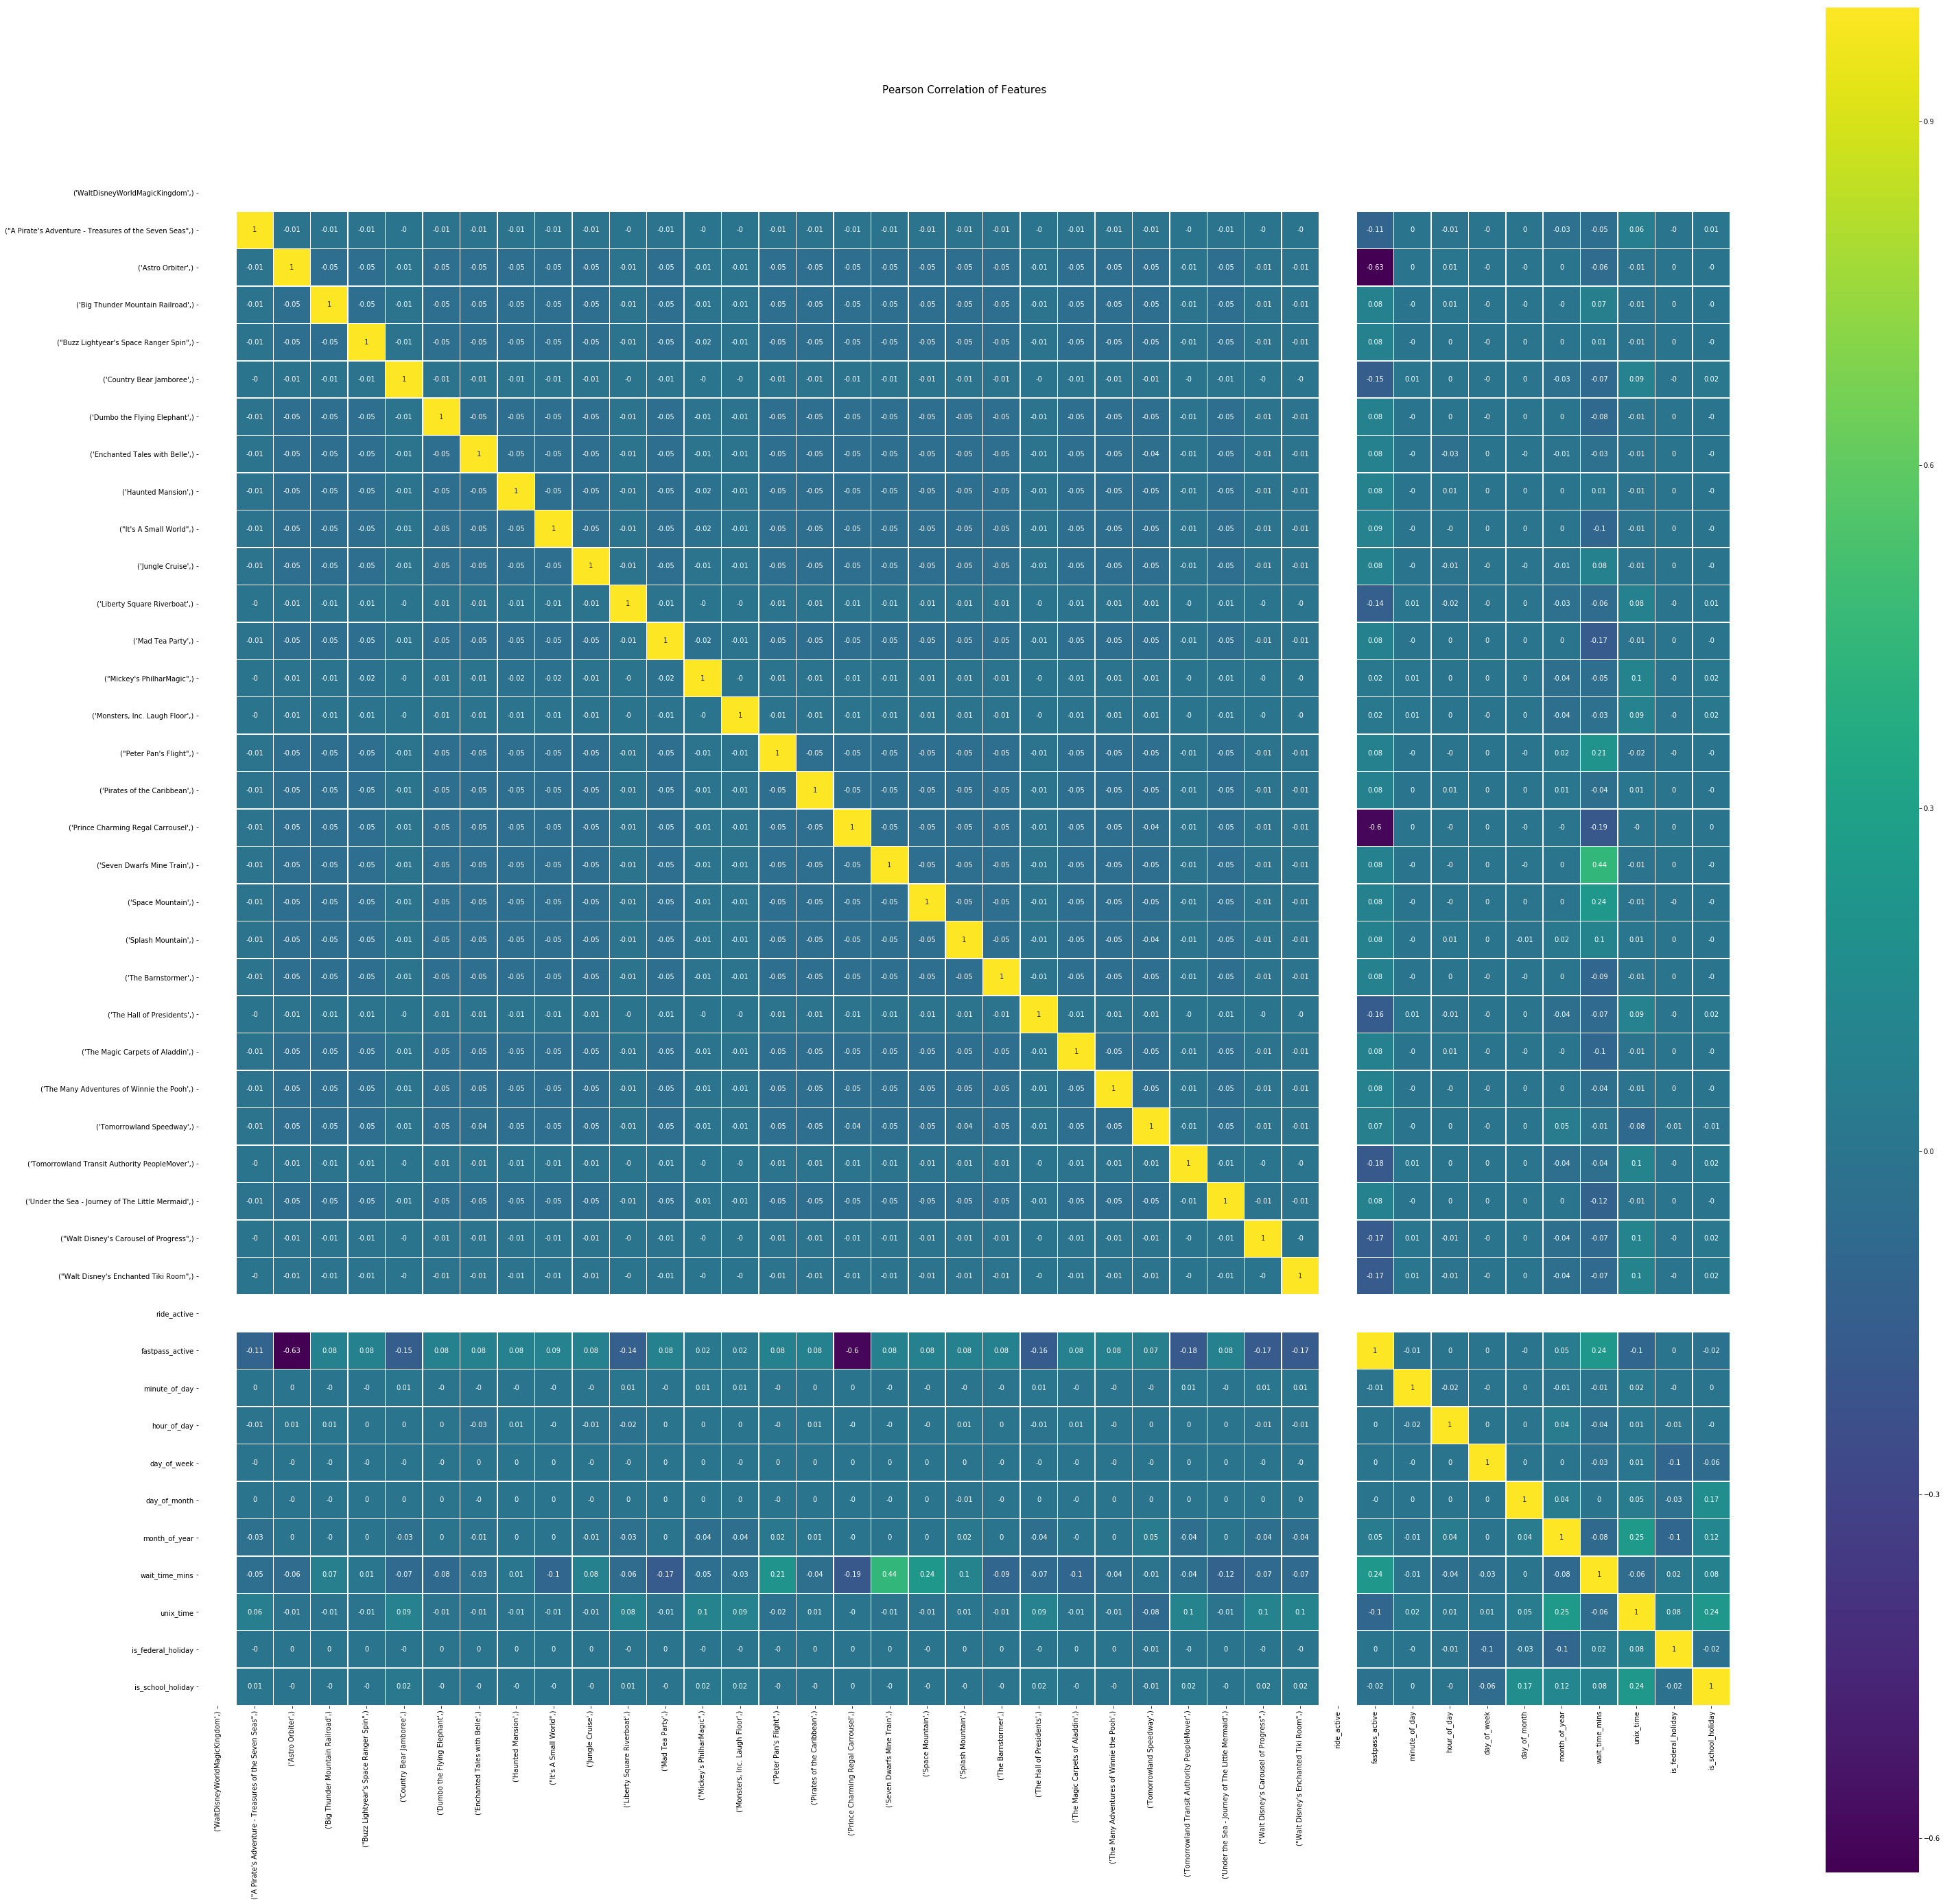

In [11]:
#View Correlation between features
colormap = plt.cm.viridis
plt.figure(figsize=(50,50), facecolor='white')
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df2.corr().round(2)\
            ,linewidths=0.5,vmax=1.0, square=True, cmap=colormap, \
            linecolor='white', annot=True);

Use SKLearn to prototype accuracies

In [0]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
# from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [0]:
print(X_train['unix_time'].dtype)

int64


In [13]:
#Using Logistic Regression
logreg = LogisticRegression()                                # instantiate
logreg.fit(X_train, Y_train)                                 # fit
Y_pred = logreg.predict(X_test)                               # predict
acc_logreg = sum(Y_pred == Y_test)/len(Y_test)*100                # evaluate

print('Logistic Regression labeling accuracy:', str(round(acc_logreg,2)),'%')

acc_log_2 = logreg.score(X_test, Y_test)                       # evaluate

print('Logistic Regression using built-in method:', str(round(acc_log_2*100,2)),'%')

Logistic Regression labeling accuracy: 11.75 %
Logistic Regression using built-in method: 11.75 %


In [14]:
#Using KNN
knn = KNeighborsClassifier(n_neighbors = 100)                  # instantiate
knn.fit(X_train, Y_train)                                    # fit
acc_knn = knn.score(X_test, Y_test)                            # predict + evaluate

print('K-Nearest Neighbors labeling accuracy:', str(round(acc_knn*100,2)),'%')

K-Nearest Neighbors labeling accuracy: 19.56 %


In [0]:
#Using SVM
# Support Vector Machines Classifier (non-linear kernel)
# svc = SVC()                                                  # instantiate
# svc.fit(X_train, Y_train)                                    # fit
# acc_svc = svc.score(X_test, Y_test)                            # predict + evaluate

# print('Support Vector Machines labeling accuracy:', str(round(acc_svc*100,2)),'%')

In [15]:
#Using Perceptron
perceptron = Perceptron()                                    # instantiate 
perceptron.fit(X_train, Y_train)                             # fit
acc_perceptron = perceptron.score(X_test, Y_test)              # predict + evalaute

print('Perceptron labeling accuracy:', str(round(acc_perceptron*100,2)),'%')

Perceptron labeling accuracy: 5.3 %


In [0]:
#Using XGBoost
# XGBoost, same API as scikit-learn
# gradboost = xgb.XGBClassifier(n_estimators=1000)             # instantiate
# gradboost.fit(X_train, Y_train)                              # fit
# acc_xgboost = gradboost.score(X_test, Y_test)                  # predict + evalute

# print('XGBoost labeling accuracy:', str(round(acc_xgboost*100,2)),'%')

In [0]:
# Using Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=300)   # instantiate
random_forest.fit(X_train, Y_train)                         # fit
acc_rf = random_forest.score(X_test, Y_test)                  # predict + evaluate

print('Random Forest Classifier labeling accuracy:', str(round(acc_rf*100,2)),'%')

In [10]:
# Using Random Forest Regressor
random_forest2 = RandomForestRegressor(n_estimators = 200)
random_forest2.fit(X_train, Y_train)                         # fit
acc_rf = random_forest2.score(X_test, Y_test)                  # predict + evaluate
print('Random Forest Regressor R^2 accuracy:', str(round(acc_rf*100,2)),'%')

Random Forest Regressor R^2 accuracy: 94.5 %


In [0]:
df3 = df2.loc[df2['wait_time_mins'] > 0]
new_X = df3.drop('wait_time_mins', axis = 1)
new_Y = df3['wait_time_mins']
new_X_train, new_X_test, new_Y_train, new_Y_test = train_test_split(new_X,new_Y, test_size = 0.3, shuffle=True)

acc_rf2 = random_forest.score(new_X_test, new_Y_test)                  # predict + evaluate

print('Random Forest R^2 accuracy:', str(round(acc_rf2*100,2)),'%')

Code below is to change accuracy metric, from R^2 to closest 5 minutes after regression

In [0]:
from collections import Counter
import math
import warnings 

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    
difference_in_time = []
for index,row in X_test.iterrows():
  pred_Y = random_forest2.predict(row.reshape(1,-1))
  difference = 5 * round((pred_Y.item(0) - Y_test.loc[index].item(0))/5)
  difference_in_time.append(difference)
# Counter(difference_in_time)

NameError: ignored

In [0]:
counter = 0
print(difference_in_time)
for index, x in enumerate(difference_in_time):
#   This was used for RandomForestClassifier
#   difference_in_time[index] = x.item(0)
    if (x > 5 or x < -5):
       counter = counter+1
# print(Counter(difference_in_time).keys())
# print(Counter(difference_in_time).values())
print(1-(counter/len(difference_in_time)))

[0, 0, 0, -5, 0, 0, 0, 0, 0, 0, 0, 0, 0, -5, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, -5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -5, 0, 0, 0, 0, 10, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, -20, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, -5, 0, 0, 0, -5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 5, 0, -10, 0, 5, 0, -5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, -5, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, -10, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, -10, 0, 5, 0, 0, 0, 0, -5, -5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -5, 0, 0, -5, 0, -5, 0, 10, 0, 0, 0, 0, 0, 0, 5, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -5, 0, 0, 5, 0, 0, 0, 0, 0, 10, 0, 0, -5, 0, 5, 0, 0, 0, 5, -5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -5, 0, -5, -5, -10, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [0]:
# This is used for error sensing
import time

timelist = []
start = time.time()
test = X_test
# print(test)
# print(test.reshape(1,-1), type(test.reshape(1,-1)))
prediction = random_forest2.predict(test)
print(prediction)
for timetaken in prediction:
  timelist.append(5 * round(timetaken/5))
end = time.time()
print(end - start)
print(timelist)


# classes = random_forest2.classes_
# classes = np.resize(classes, (8,6))
# print("classes", classes)
# print("random_forest.predict_proba", random_forest.predict_proba(test.reshape(1,-1)))
# print("random_forest.feature_importances_", random_forest.feature_importances_)
# print("random_forest.oob_score_", random_forest.oob_score_)

[44.13  0.   23.78 ... 10.08  5.   35.99]
9.384084224700928
[45.0, 0.0, 25.0, 10.0, 0.0, 10.0, 0.0, 60.0, 0.0, 35.0, 25.0, 15.0, 30.0, 0.0, 25.0, 5.0, 30.0, 0.0, 0.0, 80.0, 115.0, 40.0, 15.0, 0.0, 0.0, 40.0, 0.0, 90.0, 15.0, 80.0, 10.0, 45.0, 40.0, 65.0, 0.0, 0.0, 15.0, 10.0, 0.0, 110.0, 0.0, 10.0, 45.0, 0.0, 5.0, 60.0, 150.0, 15.0, 40.0, 0.0, 25.0, 0.0, 0.0, 35.0, 110.0, 75.0, 0.0, 0.0, 45.0, 100.0, 0.0, 30.0, 30.0, 85.0, 40.0, 60.0, 150.0, 5.0, 40.0, 0.0, 110.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 40.0, 15.0, 5.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 90.0, 5.0, 5.0, 15.0, 0.0, 95.0, 35.0, 45.0, 5.0, 15.0, 25.0, 35.0, 35.0, 25.0, 0.0, 50.0, 0.0, 25.0, 5.0, 25.0, 40.0, 30.0, 35.0, 0.0, 15.0, 40.0, 0.0, 0.0, 25.0, 75.0, 35.0, 0.0, 35.0, 0.0, 0.0, 35.0, 30.0, 0.0, 25.0, 0.0, 55.0, 85.0, 10.0, 40.0, 0.0, 30.0, 0.0, 55.0, 0.0, 0.0, 0.0, 15.0, 0.0, 40.0, 0.0, 0.0, 20.0, 20.0, 0.0, 0.0, 0.0, 25.0, 20.0, 0.0, 5.0, 110.0, 80.0, 20.0, 5.0, 10.0, 45.0, 10.0, 5.0, 25.0, 10.0, 75.0, 5.0, 0.0, 5.0, 

In [0]:
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error
predictions = random_forest2.predict(X_test)

print(f'R^2 score: {r2_score(y_true=Y_test, y_pred=predictions):.2f}')
print(f'MAE score: {mean_absolute_error(y_true=Y_test, y_pred=predictions):.2f}')
print(f'EVS score: {explained_variance_score(y_true=Y_test, y_pred=predictions):.2f}')

rp = sns.regplot(x=Y_test, y=predictions)

KeyboardInterrupt: ignored

In [17]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
from google.colab import files
import pickle

with open('smartqmodelmillion.pkl', 'wb') as file:
  print("Hello")
  pickle.dump(random_forest2, file)
  print("pickle done")
  # Install the PyDrive wrapper & import libraries.
  # This only needs to be done once in a notebook.

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'smartqmodel.pkl'})
uploaded.SetContentFile('smartqmodel.pkl')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Hello


In [0]:
import json
import requests

header = {'Content-Type': 'application/json', 
                  'Accept': 'application/json'}

send_test = X_test.loc[18002].values.reshape(1,-1).tolist()
json_file = "file.json"
json_data = json.dumps(send_test)
print(json_data)

resp = requests.post("http://35.236.127.51:5000/", 
                    data = json_data,
                    headers= header)
print(resp.json())
print("response", resp.json())
print("actual", Y_test.loc[18002])

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 20, 2, 6, 3, 1551920764, 0, 0]]
0
response 0
actual 0


In [0]:
cols = X_test.columns.tolist()
print(cols)

['WaltDisneyWorldMagicKingdom', ('"it\'s a small world"',), ("A Pirate's Adventure - Treasures of the Seven Seas",), ('Astro Orbiter',), ('Big Thunder Mountain Railroad',), ("Buzz Lightyear's Space Ranger Spin",), ("Casey Jr. Splash 'N' Soak Station",), ('Cinderella Castle',), ('Country Bear Jamboree',), ('Dumbo the Flying Elephant',), ('Enchanted Tales with Belle',), ("Frontierland Shootin' Arcade",), ('Haunted Mansion',), ('Jungle Cruise',), ('Liberty Square Riverboat',), ('Mad Tea Party',), ('Main Street Vehicles',), ("Mickey's PhilharMagic",), ('Monsters, Inc. Laugh Floor',), ("Peter Pan's Flight",), ('Pirate and Princess Adventures at Walt Disney World',), ('Pirates at Walt Disney World',), ('Pirates at Walt Disney World Resort',), ('Pirates of the Caribbean',), ('Play Disney Parks',), ('Prince Charming Regal Carrousel',), ('Seven Dwarfs Mine Train ',), ('Sorcerers of the Magic Kingdom',), ('Space Mountain',), ('Splash Mountain',), ('Swiss Family Treehouse',), ('The Barnstormer',)

In [18]:
X_test.to_csv('X_test.csv')

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'X_test.csv'})
uploaded.SetContentFile('X_test.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Y_test.to_csv('Y_test.csv')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'Y_test.csv'})
uploaded.SetContentFile('Y_test.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1XDUsOxFCLzsPMOjkdgTSq_WxtzkRLeeo
Uploaded file with ID 1uokLUa3EdrvXzGV5jPOk8-bOPRNuh6yr


In [54]:
#Rolling month long prediction
import datetime
from pytz import timezone

now = datetime.datetime.now(pytz.timezone('Etc/GMT-4'))
X_test_cols = X_test.columns.tolist()
list_of_parks = X_test_cols[0]
list_of_rides = X_test_cols[1:-10]
other_information = X_test_cols[-10::]
fastpass_active = []
for ride in list_of_rides:
  temp_df = X_test.loc[X_test[ride] == 1]
  temp_df = temp_df.reset_index()
  fastpass_active.append(temp_df.at[0, 'fastpass_active'])
tomorrow8am = now.replace(day = now.day +1, hour = 8, minute = 0, second = 0)
timedelta15mins = datetime.timedelta(minutes = 15)
timedelta10to8 = datetime.timedelta(hours = 10)
minute_of_day = []
hour_of_day = []
day_of_week = []
day_of_month = []
month_of_year = []
unix_time = []
for i in range(31):
  for n in range(56):
    minute_of_day.append(tomorrow8am.minute)
    hour_of_day.append(tomorrow8am.hour)
    day_of_week.append(tomorrow8am.weekday())
    day_of_month.append(tomorrow8am.day)
    month_of_year.append(tomorrow8am.month)
    unix_time.append(int(tomorrow8am.timestamp()))
    tomorrow8am = tomorrow8am + timedelta15mins
  tomorrow8am = tomorrow8am + timedelta10to8
all_minute_of_day = []
all_hour_of_day = []
all_day_of_week = []
all_day_of_month = []
all_month_of_year = []
all_unix_time = []
for i in range(len(list_of_rides)):
  all_minute_of_day.extend(minute_of_day)
  all_hour_of_day.extend(hour_of_day)
  all_day_of_week.extend(day_of_week)
  all_day_of_month.extend(day_of_month)
  all_month_of_year.extend(month_of_year)
  all_unix_time.extend(unix_time)
construction_theme_land_names = []
construction_ride_names = []
construction_fastpass_active = []
construction_ride_active = []
construction_is_federal_holiday = []
construction_is_school_holiday = []
for i,ride_name in enumerate(list_of_rides):
  for o in range(1736):
    construction_ride_names.append(ride_name)
    construction_theme_land_names.append(list_of_parks)
    construction_fastpass_active.append(fastpass_active[i])
    construction_ride_active.append(1)
    construction_is_federal_holiday.append(0)
    construction_is_school_holiday.append(0)
combined_numpy = np.column_stack([construction_park_names, construction_ride_names,construction_ride_active,construction_fastpass_active,all_minute_of_day,all_hour_of_day,all_day_of_week,all_day_of_month,all_month_of_year,all_unix_time,construction_is_federal_holiday,construction_is_school_holiday])
print(combined_numpy.shape)
month_prediction_df = pd.DataFrame(combined_numpy, columns = ['theme_land_name', 'ride_name', 'ride_active', 'fastpass_active', 'minute_of_hour', 'hour_of_day', 'day_of_week', 'day_of_month', 'month_of_year','unix_time','is_federal_holiday','is_school_holiday'])
month_prediction_df

    
  
    
    



(50344, 12)


,theme_land_name,ride_name,ride_active,fastpass_active,minute_of_hour,hour_of_day,day_of_week,day_of_month,month_of_year,unix_time,is_federal_holiday,is_school_holiday
0,WaltDisneyWorldMagicKingdom,A Pirate's Adventure - Treasures of the Seven ...,1,0,0,8,3,2,5,1556769600,0,0
1,WaltDisneyWorldMagicKingdom,A Pirate's Adventure - Treasures of the Seven ...,1,0,15,8,3,2,5,1556770500,0,0
2,WaltDisneyWorldMagicKingdom,A Pirate's Adventure - Treasures of the Seven ...,1,0,30,8,3,2,5,1556771400,0,0
3,WaltDisneyWorldMagicKingdom,A Pirate's Adventure - Treasures of the Seven ...,1,0,45,8,3,2,5,1556772300,0,0
4,WaltDisneyWorldMagicKingdom,A Pirate's Adventure - Treasures of the Seven ...,1,0,0,9,3,2,5,1556773200,0,0
5,WaltDisneyWorldMagicKingdom,A Pirate's Adventure - Treasures of the Seven ...,1,0,15,9,3,2,5,1556774100,0,0
6,WaltDisneyWorldMagicKingdom,A Pirate's Adventure - Treasures of the Seven ...,1,0,30,9,3,2,5,1556775000,0,0
7,WaltDisneyWorldMagicKingdom,A Pirate's Adventure - Treasures of the Seven ...,1,0,45,9,3,2,5,1556775900,0,0
8,WaltDisneyWorldMagicKingdom,A Pirate's Adventure - Treasures of the Seven ...,1,0,0,10,3,2,5,1556776800,0,0
9,WaltDisneyWorldMagicKingdom,A Pirate's Adventure - Treasures of the Seven ...,1,0,15,10,3,2,5,1556777700,0,0


In [55]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
theme_land_name = month_prediction_df['theme_land_name']
ride_name = month_prediction_df['ride_name']
one_hot_encoder = OneHotEncoder(categories = 'auto', sparse = False)

one_hot_encoded_theme_land = np.asarray(one_hot_encoder.fit_transform(theme_land_name.values.reshape(len(theme_land_name),1)))
theme_land_categories = np.asarray(one_hot_encoder.categories_)                         
print("theme_land_categories", theme_land_categories)

one_hot_encoded_ride_name = np.asarray(one_hot_encoder.fit_transform(ride_name.values.reshape(len(ride_name),1)))
ride_name_categories = np.asarray(one_hot_encoder.categories_)
ride_name_categories = np.transpose(ride_name_categories)
print("ride_name_categories", np.shape(ride_name_categories))

print("one_hot_encoded_theme_land", one_hot_encoded_theme_land)
print("one_hot_encoded_ride_name", one_hot_encoded_ride_name)

#Join back to main DF
df_temp1 = pd.DataFrame(one_hot_encoded_theme_land, columns = theme_land_categories)
df_temp2 = pd.DataFrame(one_hot_encoded_ride_name, columns = ride_name_categories)
month_prediction_df = month_prediction_df.reset_index(drop=True)
month_prediction_df = pd.concat([df_temp1, df_temp2, month_prediction_df],axis=1, join = 'outer')
month_prediction_df = month_prediction_df.drop(['theme_land_name', 'ride_name'], axis = 1)
month_prediction_df = month_prediction_df.astype('int64')
month_prediction_df

theme_land_categories [['WaltDisneyWorldMagicKingdom']]
ride_name_categories (29, 1)
one_hot_encoded_theme_land [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
one_hot_encoded_ride_name [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


,"(WaltDisneyWorldMagicKingdom,)","(A Pirate's Adventure - Treasures of the Seven Seas,)","(Astro Orbiter,)","(Big Thunder Mountain Railroad,)","(Buzz Lightyear's Space Ranger Spin,)","(Country Bear Jamboree,)","(Dumbo the Flying Elephant,)","(Enchanted Tales with Belle,)","(Haunted Mansion,)","(It's A Small World,)","(Jungle Cruise,)","(Liberty Square Riverboat,)","(Mad Tea Party,)","(Mickey's PhilharMagic,)","(Monsters, Inc. Laugh Floor,)","(Peter Pan's Flight,)","(Pirates of the Caribbean,)","(Prince Charming Regal Carrousel,)","(Seven Dwarfs Mine Train,)","(Space Mountain,)","(Splash Mountain,)","(The Barnstormer,)","(The Hall of Presidents,)","(The Magic Carpets of Aladdin,)","(The Many Adventures of Winnie the Pooh,)","(Tomorrowland Speedway,)","(Tomorrowland Transit Authority PeopleMover,)","(Under the Sea - Journey of The Little Mermaid,)","(Walt Disney's Carousel of Progress,)","(Walt Disney's Enchanted Tiki Room,)",ride_active,fastpass_active,minute_of_hour,hour_of_day,day_of_week,day_of_month,month_of_year,unix_time,is_federal_holiday,is_school_holiday
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,8,3,2,5,1556769600,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,15,8,3,2,5,1556770500,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,30,8,3,2,5,1556771400,0,0
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,45,8,3,2,5,1556772300,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,9,3,2,5,1556773200,0,0
5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,15,9,3,2,5,1556774100,0,0
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,30,9,3,2,5,1556775000,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,45,9,3,2,5,1556775900,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10,3,2,5,1556776800,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,15,10,3,2,5,1556777700,0,0
